In [2]:
import polars as pl
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Processar arquivos txt e transformar em um dataframe

In [3]:
schema = {
    "index": pl.UInt64,
    "f": pl.Float64,
    "amplitude": pl.Float64,
    "run": pl.Int64,
    "type": pl.String,
}
experiment_data = pl.DataFrame(schema=schema)

pathlist = sorted(Path("experimento3").rglob("*.txt"))

for path in pathlist:
    n_rows = 6401
    run = int(re.findall(r"[Input](\d+)", str(path))[0])
    type = re.findall(r"\d+GDL\w*", str(path))[0]

    df = pl.read_csv(
        path,
        has_header=False,
        new_columns=["index", "f", "amplitude"],
        schema=schema,
        separator="\t",
        skip_rows=83,
        n_rows=n_rows,
        ignore_errors=True,
    ).with_columns(
        pl.lit(run).cast(pl.Int64).alias("run"),
        pl.lit(type).alias("type"),
    )
    experiment_data = pl.concat([experiment_data, df])

In [4]:
experiment_data

index,f,amplitude,run,type
u64,f64,f64,i64,str
1,0.0,0.000019,1,"""1GDL"""
2,0.078125,0.000019,1,"""1GDL"""
3,0.15625,0.000009,1,"""1GDL"""
4,0.234375,0.000003,1,"""1GDL"""
5,0.3125,0.000013,1,"""1GDL"""
…,…,…,…,…
6397,499.6875,5.2329e-9,4,"""2GDLbarra"""
6398,499.765625,8.3805e-9,4,"""2GDLbarra"""
6399,499.84375,1.0454e-8,4,"""2GDLbarra"""


#### 1. Sistema de 1GL

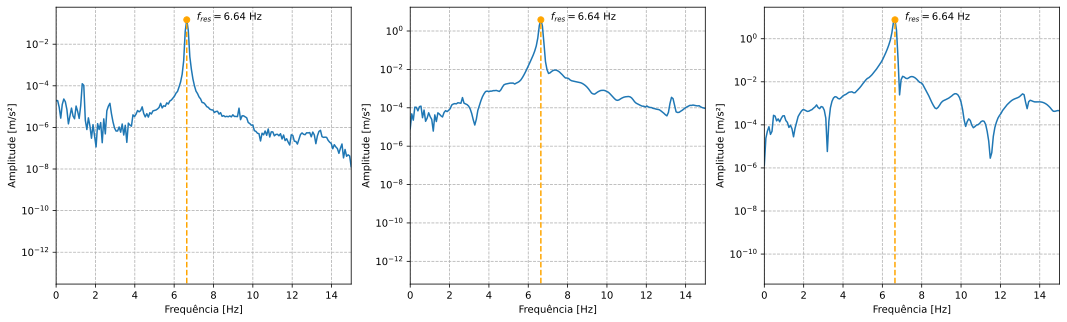

mean,stddev
f64,f64
6.640625,0.0


In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

df_1gl = (
    experiment_data.filter(
        (pl.col("type") ==  "1GDL")
    )
    .sort(by=["run", "index"])
    .select("f", "amplitude", "run")
)

df_1gl_ressonances = pl.DataFrame(schema=df_1gl.schema)

for idx, ax in enumerate(axs.flat):
    current_run = df_1gl.filter(pl.col("run") == (idx + 1))
    ressonance = current_run.filter(pl.col("amplitude") == pl.col("amplitude").max())
    df_1gl_ressonances = pl.concat([df_1gl_ressonances, ressonance])

    ax.semilogy(
        current_run.select("f"), current_run.select("amplitude")
    )  # half-power  band
    ax.annotate(
        rf"$f_{{res}} = {round(ressonance.select('f').item(), 2)}~\text{{Hz}}$",
        (ressonance.select("f").item(), ressonance.select("amplitude").item()),
        (1, 0),
        textcoords="offset fontsize",
    )
    # ax.axhline(
    #     ressonance.select(pl.col("amplitude") / np.sqrt(2)).item(),
    #     linestyle="--",
    #     color="magenta",
    # )
    markerline, stemlines, baseline = ax.stem(
        ressonance.select("f").to_numpy(),
        ressonance.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 15))
    # ax.set_ylim((0, 0.5))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

plt.savefig("experimento3/sistema_1gl.svg", format="svg", bbox_inches="tight")
plt.show()

display(df_1gl_ressonances.select(pl.col("f").mean().alias("mean"), pl.col("f").std().alias("stddev")))

#### 2. Sistema de 2GL

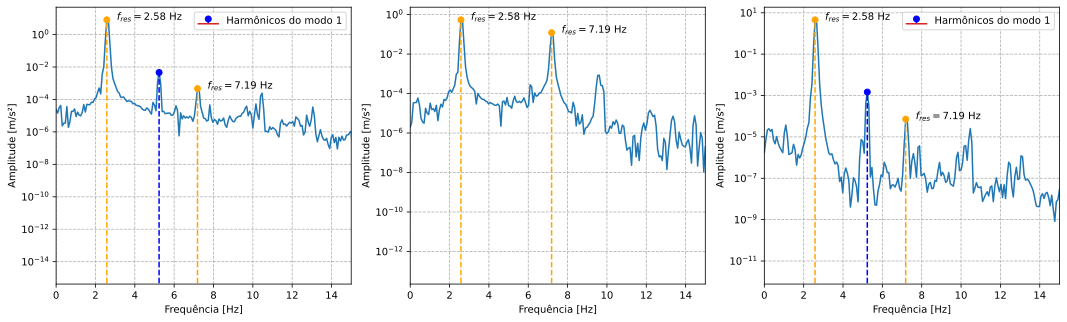

modo,mean,stddev
str,f64,f64
"""modo 1""",7.1875,0.0
"""modo 2""",2.578125,0.0


In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

df_2gl = (
    experiment_data.filter(
        (pl.col("type") == "2GDL")
    )
    .sort(by=["run", "index"])
    .select("f", "amplitude", "run")
)

df_2gl_ressonances = pl.DataFrame(schema=df_2gl.schema)

for idx, ax in enumerate(axs.flat):
    current_run = df_2gl.filter(pl.col("run") == (idx + 1))
    ressonances = current_run.top_k(1, by="amplitude")
    harmonics = pl.DataFrame(schema={"f": pl.Float64, "amplitude": pl.Float64})
    
    # xunxo master xGH
    match (idx+1):
        case 1:
            ressonances.extend(pl.DataFrame({"f": [7.1875], "amplitude": [464.852e-6], "run": [None]}))
            harmonics.extend(pl.DataFrame({"f": [5.234375], "amplitude": [0.00459151]}))
        case 2:
            ressonances.extend(pl.DataFrame({"f": [7.1875], "amplitude": [0.121026], "run": [None]}))
            harmonics.extend(pl.DataFrame({"f": [None], "amplitude": [None]}))
        case 3:
            ressonances.extend(pl.DataFrame({"f": [7.1875], "amplitude": [72.0862e-6], "run": [None]}))
            harmonics.extend(pl.DataFrame({"f": [5.234375], "amplitude": [0.00146755]}))

    df_2gl_ressonances = pl.concat([df_2gl_ressonances, ressonances])

    ax.semilogy(current_run.select("f"), current_run.select("amplitude"))
 
    for res in ressonances.iter_rows(named=True):
        ax.annotate(
            rf"$f_{{res}} = {round(res["f"], 2)}~\text{{Hz}}$",
            (res["f"], res["amplitude"]),
            (1, 0),
            textcoords="offset fontsize",
        )
    
    markerline, stemlines, baseline = ax.stem(
        ressonances.select("f").to_numpy(),
        ressonances.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    markerline, stemlines, baseline = ax.stem(
        harmonics.select("f").to_numpy(),
        harmonics.select("amplitude").to_numpy(),
        markerfmt="o",
        label="Harmônicos do modo 1"
    )
    plt.setp(markerline, "color", "blue")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "blue")

    ax.set_xlim((0, 15))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

axs[0].legend()
axs[2].legend()

plt.savefig("experimento3/sistema_2gl.svg", format="svg", bbox_inches="tight")
plt.show()

display(
    df_2gl_ressonances
    .with_columns(
        pl.when(pl.col("run").is_not_null())
          .then(pl.lit("modo 2"))
          .otherwise(pl.lit("modo 1")).alias("modo")
    )
    .group_by("modo")
    .agg(pl.col("f").mean().alias("mean"), pl.col("f").std().alias("stddev"))
)

#### 3. Sistema de 2GL com barra engastada

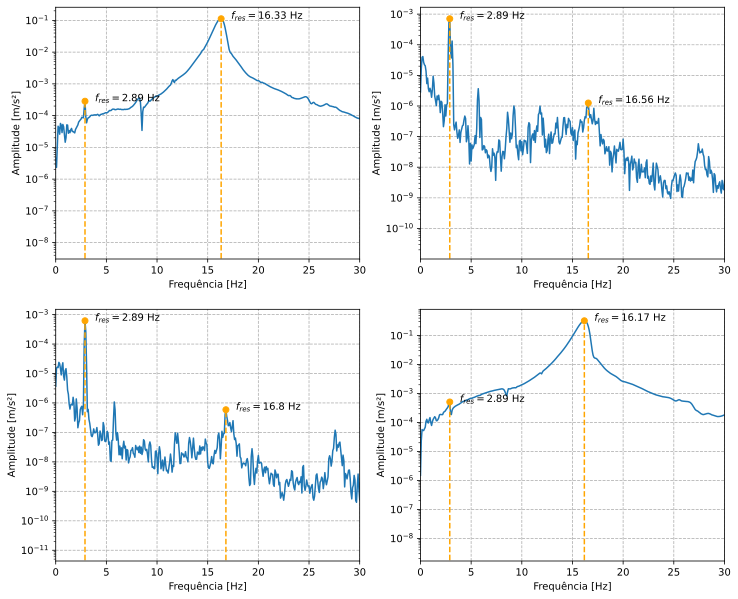

modo,mean,stddev
str,f64,f64
"""Excitação na massa 1""",16.25,0.110485
"""Excitação na massa 2""",2.890625,0.0


In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

df_2gl_barra = (
    experiment_data.filter(
        (pl.col("type") == "2GDLbarra")
    )
    .sort(by=["run", "index"])
    .select("f", "amplitude", "run")
)

df_2gl_barra_ressonances = pl.DataFrame(schema=df_2gl_barra.schema)

for idx, ax in enumerate(axs.flat):
    current_run = df_2gl_barra.filter(pl.col("run") == (idx + 1))
    ressonances = current_run.top_k(1, by="amplitude")
    harmonics = pl.DataFrame(schema={"f": pl.Float64, "amplitude": pl.Float64})
    
    df_2gl_barra_ressonances = pl.concat([df_2gl_barra_ressonances, ressonances])

    ax.semilogy(current_run.select("f"), current_run.select("amplitude")) 

    # xunxo master xGH
    match (idx+1):
        case 1:
            ressonances.extend(pl.DataFrame({"f": [2.890625], "amplitude": [284.702e-6], "run": [None]}))
        case 2:
            ressonances.extend(pl.DataFrame({"f": [16.5625], "amplitude": [1.2543e-6], "run": [None]}))
        case 3:
            ressonances.extend(pl.DataFrame({"f": [16.79687], "amplitude": [590.211e-9], "run": [None]}))
        case 4:
            ressonances.extend(pl.DataFrame({"f": [2.890625], "amplitude": [510.818e-6], "run": [None]}))

    for res in ressonances.iter_rows(named=True):
        ax.annotate(
            rf"$f_{{res}} = {round(res["f"], 2)}~\text{{Hz}}$",
            (res["f"], res["amplitude"]),
            (1, 0),
            textcoords="offset fontsize",
        )

    markerline, stemlines, baseline = ax.stem(
        ressonances.select("f").to_numpy(),
        ressonances.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 30))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [m/s²]")
    ax.grid(axis="both", linestyle="--")

plt.savefig("experimento3/sistema_2gl_barra.svg", format="svg", bbox_inches="tight")
plt.show()

display(
    df_2gl_barra_ressonances
    .with_columns(
        pl.when(pl.col("run").is_in([2, 3]))
          .then(pl.lit("Excitação na massa 2"))
          .otherwise(pl.lit("Excitação na massa 1")).alias("modo")
    )
    .group_by("modo")
    .agg(pl.col("f").mean().alias("mean"), pl.col("f").std().alias("stddev"))
)

In [10]:
fig = px.line(df_2gl.filter(pl.col("run") == 3), x="f", y="amplitude", title="Sistema 2GL", log_y=True, log_x=True)
fig.show()